In [ ]:
cd drive/MyDrive/


/content/drive/MyDrive


In [ ]:
cd KHDL_IT4930/model/

/content/drive/MyDrive/KHDL_IT4930/model


In [ ]:
ls

ANN.ipynb  predict_car_prices_use_knn.ipynb  Regression.ipynb


In [ ]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
cars = pd.read_csv('../dataset/data.csv', error_bad_lines=False, delimiter='\t')
print(cars.shape)
cars.head()

(41148, 12)


,Unnamed: 0,kieu_dang,hop_so,km_da_di,nhien_lieu,so_cho_ngoi,tinh_trang,xuat_xu,nam_sx,gia,dong_xe,hang
0,0,Sedan,Tự động,9000,Xăng,5,Đã sử dụng,Lắp ráp trong nước,2019,4.480000e+09,Sclass,Mercedes Benz
1,1,Sedan,Tự động,20000,Xăng,5,Đã sử dụng,Lắp ráp trong nước,2017,1.155000e+09,Cclass,Mercedes Benz
2,2,SUV / Cross over,Tự động,0,Xăng,5,Mới,Lắp ráp trong nước,2021,5.790000e+08,Kona,Hyundai
3,3,SUV / Cross over,Tự động,0,Xăng,5,Mới,Lắp ráp trong nước,2021,8.250000e+08,Tucson,Hyundai
4,4,Sedan,Tự động,32000,Xăng,4,Đã sử dụng,Nhập khẩu,2017,5.750000e+09,Panamera,Porsche


In [ ]:
data = pd.get_dummies(cars, columns=['tinh_trang', 'hang', 'dong_xe', 'xuat_xu', 'kieu_dang', 'nhien_lieu', 'hop_so'])

In [ ]:
data

,Unnamed: 0,km_da_di,so_cho_ngoi,nam_sx,gia,tinh_trang_Mới,tinh_trang_Đã sử dụng,hang_Acura,hang_Audi,hang_BMW,hang_Bentley,hang_Cadillac,hang_Chery,hang_Chevrolet,hang_Chrysler,hang_Daewoo,hang_Daihatsu,hang_Dodge,hang_Dongben,hang_Ferrari,hang_Fiat,hang_Ford,hang_Honda,hang_Hyundai,hang_Infiniti,hang_Isuzu,hang_Jaguar,hang_Jeep,hang_Kia,hang_LandRover,hang_Lexus,hang_Lifan,hang_Lincoln,hang_MG,hang_Maserati,hang_Mazda,hang_Mercedes Benz,hang_Mini,hang_Mitsubishi,hang_Nissan,...,dong_xe_X3,dong_xe_X4,dong_xe_X5,dong_xe_X6,dong_xe_X7,dong_xe_XC40,dong_xe_XC60,dong_xe_XC90,dong_xe_XF,dong_xe_XJseries,dong_xe_XL7,dong_xe_XTerra,dong_xe_Xpander,dong_xe_XpanderCross,dong_xe_Xtrail,dong_xe_Yaris,dong_xe_Z4,dong_xe_Z8,dong_xe_ZS,dong_xe_Zace,dong_xe_Zinger,xuat_xu_Lắp ráp trong nước,xuat_xu_Nhập khẩu,kieu_dang_Bán tải / Pickup,kieu_dang_Convertible/Cabriolet,kieu_dang_Coupe,kieu_dang_Hatchback,kieu_dang_Mui trần,kieu_dang_SUV / Cross over,kieu_dang_Sedan,kieu_dang_Truck,kieu_dang_Van/Minivan,kieu_dang_Wagon,nhien_lieu_Dầu,nhien_lieu_Hybrid,nhien_lieu_Xăng,nhien_lieu_Điện,hop_so_Bán tự động,hop_so_Số sàn,hop_so_Tự động
0,0,9000,5,2019,4.480000e+09,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
1,1,20000,5,2017,1.155000e+09,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
2,2,0,5,2021,5.790000e+08,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
3,3,0,5,2021,8.250000e+08,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
4,4,32000,4,2017,5.750000e+09,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41143,41143,200000,8,2009,2.800000e+08,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
41144,41144,38000,5,2018,5.630000e+08,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
41145,41145,70000,5,2009,1.850000e+08,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
41146,41146,2555,5,1999,4.250000e+07,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0


In [ ]:
del data['Unnamed: 0']

In [ ]:
data.dtypes

km_da_di                int64
so_cho_ngoi             int64
nam_sx                  int64
gia                   float64
tinh_trang_Mới          uint8
                       ...   
nhien_lieu_Xăng         uint8
nhien_lieu_Điện         uint8
hop_so_Bán tự động      uint8
hop_so_Số sàn           uint8
hop_so_Tự động          uint8
Length: 391, dtype: object

In [ ]:
normal_data = (data - data.min())/(data.max() - data.min())
# normal_data.gia = data.gia

In [ ]:
normal_data

,km_da_di,so_cho_ngoi,nam_sx,gia,tinh_trang_Mới,tinh_trang_Đã sử dụng,hang_Acura,hang_Audi,hang_BMW,hang_Bentley,hang_Cadillac,hang_Chery,hang_Chevrolet,hang_Chrysler,hang_Daewoo,hang_Daihatsu,hang_Dodge,hang_Dongben,hang_Ferrari,hang_Fiat,hang_Ford,hang_Honda,hang_Hyundai,hang_Infiniti,hang_Isuzu,hang_Jaguar,hang_Jeep,hang_Kia,hang_LandRover,hang_Lexus,hang_Lifan,hang_Lincoln,hang_MG,hang_Maserati,hang_Mazda,hang_Mercedes Benz,hang_Mini,hang_Mitsubishi,hang_Nissan,hang_Peugeot,...,dong_xe_X3,dong_xe_X4,dong_xe_X5,dong_xe_X6,dong_xe_X7,dong_xe_XC40,dong_xe_XC60,dong_xe_XC90,dong_xe_XF,dong_xe_XJseries,dong_xe_XL7,dong_xe_XTerra,dong_xe_Xpander,dong_xe_XpanderCross,dong_xe_Xtrail,dong_xe_Yaris,dong_xe_Z4,dong_xe_Z8,dong_xe_ZS,dong_xe_Zace,dong_xe_Zinger,xuat_xu_Lắp ráp trong nước,xuat_xu_Nhập khẩu,kieu_dang_Bán tải / Pickup,kieu_dang_Convertible/Cabriolet,kieu_dang_Coupe,kieu_dang_Hatchback,kieu_dang_Mui trần,kieu_dang_SUV / Cross over,kieu_dang_Sedan,kieu_dang_Truck,kieu_dang_Van/Minivan,kieu_dang_Wagon,nhien_lieu_Dầu,nhien_lieu_Hybrid,nhien_lieu_Xăng,nhien_lieu_Điện,hop_so_Bán tự động,hop_so_Số sàn,hop_so_Tự động
0,0.000030,0.066667,0.951220,0.065443,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.000067,0.066667,0.902439,0.016522,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.000000,0.066667,1.000000,0.008048,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.000000,0.066667,1.000000,0.011667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.000107,0.044444,0.902439,0.084128,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41143,0.000667,0.133333,0.707317,0.003649,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
41144,0.000127,0.066667,0.926829,0.007812,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
41145,0.000233,0.066667,0.707317,0.002251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
data.gia.describe()

count    4.114800e+04
mean     8.001651e+08
std      1.560205e+09
min      3.200000e+07
25%      2.850000e+08
50%      4.750000e+08
75%      7.500000e+08
max      6.800000e+10
Name: gia, dtype: float64

In [ ]:
# Univariate model
def knn_train_test_uni(feature, target_column, df, k):
    
    # Randomize order of rows in data frame.
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Split the dataset 5-5
    train_set = rand_df.iloc[0:int(len(rand_df)/2)]
    test_set = rand_df.iloc[int(len(rand_df)/2):]
    
    # Train
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(train_set[[feature]], train_set[target_column])
    
    # Predict
    predictions = knn.predict(test_set[[feature]])
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_set[target_column], predictions))
    
    return rmse

In [ ]:
k_values = [5]
rmse_uni = {}
current_rmse = []
target_column = 'gia'

continuous_numeric = ['km_da_di', 'so_cho_ngoi', 'nam_sx', 'gia']

for feature in continuous_numeric[0:-1]:
    for k in k_values:
        current_rmse.append(knn_train_test_uni(feature, target_column, normal_data, k))
        
    rmse_uni[feature] = current_rmse
    current_rmse = []

rmse_uni

{'km_da_di': [0.022833832938504838],
 'nam_sx': [0.022671816132297493],
 'so_cho_ngoi': [0.022419276020024984]}

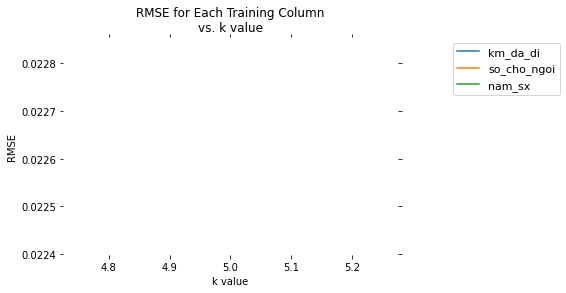

In [ ]:
fig, ax = plt.subplots(1)

for key, values in rmse_uni.items():
    ax.plot(k_values, values, label=key)
    ax.set_xlabel('k value')
    ax.set_ylabel('RMSE')
    ax.set_title('RMSE for Each Training Column\nvs. k value')
    ax.tick_params(top="off", left="off", right="off", bottom='off')
    ax.legend(bbox_to_anchor=(1.5, 1), prop={'size': 11})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

In [ ]:
# Multivariate model
def knn_train_test(features, target_column, df, k):
    
    # Randomize order of rows in data frame.
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Split the dataset
    train_set = rand_df.iloc[0:int(len(rand_df)/2)]
    test_set = rand_df.iloc[int(len(rand_df)/2):]
    
    # Train
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(train_set[features], train_set[target_column])
    
    # Predict
    predictions = knn.predict(test_set[features])
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_set[target_column], predictions))
    
    return rmse

In [ ]:
avg_rmse = {}

for key, values in rmse_uni.items():
    avg_rmse[key] = np.mean(values)

avg_rmse = pd.Series(avg_rmse)
avg_rmse.sort_values()

so_cho_ngoi    0.022419
nam_sx         0.022672
km_da_di       0.022834
dtype: float64

In [ ]:
columns = data.columns

import re


categories = ['kieu_dang', 'hop_so', 'nhien_lieu', 'tinh_trang', 'xuat_xu', 'dong_xe', 'hang']
total = []

for c in categories:
  p = re.compile(c)
  lis = [ s for s in columns if p.match(s)]
  total.append(lis)

total

[['kieu_dang_Bán tải / Pickup',
  'kieu_dang_Convertible/Cabriolet',
  'kieu_dang_Coupe',
  'kieu_dang_Hatchback',
  'kieu_dang_Mui trần',
  'kieu_dang_SUV / Cross over',
  'kieu_dang_Sedan',
  'kieu_dang_Truck',
  'kieu_dang_Van/Minivan',
  'kieu_dang_Wagon'],
 ['hop_so_Bán tự động', 'hop_so_Số sàn', 'hop_so_Tự động'],
 ['nhien_lieu_Dầu', 'nhien_lieu_Hybrid', 'nhien_lieu_Xăng', 'nhien_lieu_Điện'],
 ['tinh_trang_Mới', 'tinh_trang_Đã sử dụng'],
 ['xuat_xu_Lắp ráp trong nước', 'xuat_xu_Nhập khẩu'],
 ['dong_xe_190',
  'dong_xe_1Series',
  'dong_xe_2',
  'dong_xe_2008',
  'dong_xe_208',
  'dong_xe_2Series',
  'dong_xe_3',
  'dong_xe_3008',
  'dong_xe_300C',
  'dong_xe_323',
  'dong_xe_3Series',
  'dong_xe_4Runner',
  'dong_xe_4Series',
  'dong_xe_5',
  'dong_xe_500',
  'dong_xe_5008',
  'dong_xe_508',
  'dong_xe_520',
  'dong_xe_5Series',
  'dong_xe_6',
  'dong_xe_626',
  'dong_xe_718',
  'dong_xe_7Series',
  'dong_xe_911',
  'dong_xe_A1',
  'dong_xe_A2',
  'dong_xe_A3',
  'dong_xe_A4',


In [ ]:
features = {
        'kieu_dang': total[0],
        'hop_so': total[1],
        'nhien_lieu': total[2],
        'tinh_trang': total[3],
        'xuat_xu': total[4],
        'dong_xe': total[5],
        'hang': total[6],
    } 

rmse_uti_onehot = {}
target_column = 'gia'
k = 5

for key, value in features.items():
    rmse_uti_onehot[key] = knn_train_test(value, target_column, normal_data, k)
    
pd.Series(rmse_uti_onehot).sort_values()

dong_xe       0.013029
hang          0.016262
tinh_trang    0.022364
xuat_xu       0.022557
hop_so        0.022744
kieu_dang     0.023419
nhien_lieu    0.023431
dtype: float64

In [ ]:
type(total[0])

list

In [ ]:
data.columns

Index(['km_da_di', 'so_cho_ngoi', 'nam_sx', 'gia', 'tinh_trang_Mới',
       'tinh_trang_Đã sử dụng', 'hang_Acura', 'hang_Audi', 'hang_BMW',
       'hang_Bentley',
       ...
       'kieu_dang_Truck', 'kieu_dang_Van/Minivan', 'kieu_dang_Wagon',
       'nhien_lieu_Dầu', 'nhien_lieu_Hybrid', 'nhien_lieu_Xăng',
       'nhien_lieu_Điện', 'hop_so_Bán tự động', 'hop_so_Số sàn',
       'hop_so_Tự động'],
      dtype='object', length=391)

In [ ]:
list_feature_no_price = [i for i in data.columns if i != 'gia']

In [ ]:
top_6_feature = [i for i in list_feature_no_price if 'dong_xe' in i or 'hang' in i or 'hop_so' in i or 'km_da_di' in i or 'so_cho_ngoi' in i or 'nam_sx' in i]

In [ ]:
# chọn 2 model tốt nhất  ở bên trên để hyperparameter turning k

top_models = {
  'best_2': list_feature_no_price, # tat ca du lieu, 
  'best_3': top_6_feature
}

k_values = list(range(1, 26))
rmse_multi_k = {}
rmse_current = []

for key, value in top_models.items():
    for k in k_values:
        rmse_current.append(knn_train_test(value, target_column, normal_data, k))
        
    rmse_multi_k[key] = rmse_current
    rmse_current = []
    
print(rmse_multi_k)

{'best_2': [0.0076874049738083405, 0.0071496461416484, 0.007483959616579684, 0.007071128490219041, 0.007137190406819642, 0.0076415337751637, 0.00820058729265009, 0.008535299926187285, 0.008601676628598369, 0.008739295994155714, 0.008914552963537539, 0.00904103595430041, 0.009247747646676375, 0.009467545544820688, 0.009636115905883716, 0.009707330839115028, 0.009911770911655647, 0.010121864345129827, 0.010311286993024762, 0.010429909988686798, 0.010590949959930533, 0.010753685542316519, 0.010989809414139056, 0.011153277235949617, 0.011232241910170478], 'best_3': [0.007429812349014016, 0.007081731177249452, 0.007726755834442089, 0.00807072123404028, 0.008517188620431253, 0.008175029030472056, 0.008011153280954864, 0.007998308821509413, 0.00825074305157019, 0.00820493964311483, 0.008263845393755662, 0.008552179662618533, 0.00884086948435066, 0.009099540029686047, 0.009377515723900547, 0.009590669024310177, 0.009793838218922137, 0.00988419016799433, 0.009948206864731328, 0.0100384043687404

{'best_2': [0.007071128490219041, 3], 'best_3': [0.007081731177249452, 1]}


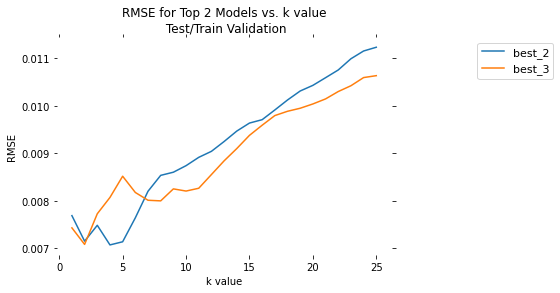

In [ ]:
# Returns a dict with the min value of every key's list and its index the list
def min_key_value(dictionary):
    min_values = {}
    for k, v in dictionary.items():
        min_values[k] = [min(v), v.index(min(v))]
        
    return min_values
        
best_k = min_key_value(rmse_multi_k)
print(best_k)

# Plot results
fig, ax = plt.subplots(1)

for key, values in rmse_multi_k.items():
    ax.plot(k_values, values, label=key)
    ax.set_xlabel('k value')
    ax.set_ylabel('RMSE')
    ax.set_title('RMSE for Top 2 Models vs. k value\n Test/Train Validation')
    ax.tick_params(top="off", left="off", right="off", bottom='off')
    ax.legend(bbox_to_anchor=(1.5, 1), prop={'size': 11})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)